In [1]:
import tejapi
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

tejapi.ApiConfig.api_key  = "Your Key"
tejapi.ApiConfig.api_base = "https://api.tej.com.tw"
tejapi.ApiConfig.ignoretz = True

In [2]:
# 取得內部人申報轉讓資料，並篩選出鉅額交易的資料
data_trans = tejapi.get('TWN/ATRANS',        # 上市(櫃)董監申報轉讓資料庫
                        # 證券碼、申報日、股東身份、轉讓方式、申報轉讓股數
                        opts = {'columns':['coid', 'mdate', 'clnm_c', 'tpnm_c', 'tns2']},
                        paginate = True,
                        chinese_column_name = True)
data_trans = data_trans[data_trans['轉讓方式'].str.contains('鉅額')]  # 篩選鉅額交易資料

In [3]:
# 取得總發行股數函數，將證券碼、日期設為變數
def data_total_stock(coid, date):
# 由於此資料庫將日期設為次月15號更新，本次實作2024/01的資料尚未發布，所以若有2023/12/01之後的事件都以2023/12/01取得總發行股數
    reference_date = datetime.strptime('2023-12-01', '%Y-%m-%d')
    date_object = datetime.strptime(date, '%Y-%m-%d')   # 將日期變數轉為datetime格式
# 判斷日期是否在2023/12/01之後，若在之後以2023/12/01取得總發行股數
    if date_object > reference_date:
        gte = reference_date
        lte = reference_date
# 若在2023/12/01之前，此資料是月頻率的資料，因此若日期不是1號，則取這個月到下個月之間的那個1號，反之則不用改變日期
    else:
        gte = date                    # 設置開始日期
        if date_object.day != 1:
            next_month_date = date_object + relativedelta(months=1)    # 加一個月
        else:
            next_month_date = date_object                  # 原日期即可
        lte = next_month_date.strftime('%Y-%m-%d')         # 設置結束日期
    data_total = tejapi.get('TWN/ABSTN1',                  # 上市(櫃)董監全體持股狀況資料庫   
                            coid = coid,
                            mdate = {'gte':gte, 'lte':lte},
                            opts = {'columns':['coid','fld003']},    # 證券碼、總發行股數
                            paginate = True,
                            chinese_column_name = True)  
    return data_total

In [4]:
# 取得股價函數，將證券碼、起迄日期設為變數
def data_stock_price(coid, start, end):
    data_coid = tejapi.get('TWN/APRCD',            # 上市(櫃)未調整股價(日)資料庫
                            coid = coid,
                            mdate = {'gte':start, 'lte': end},
                            paginate = True,
                            chinese_column_name = True,
                            opts = {'columns':['coid','mdate','close_d']},      #證券碼、日期、收盤價
                            )
    return data_coid

In [5]:
# 下面兩個欄位轉成list資料，以便後續帶入函數
coid = list(data_trans['公司碼'])
date = list(data_trans['申報日'])

# 設置總發行股數的dataframe
data_total = pd.DataFrame()

for x, y in zip(coid, date):
    data_stock = data_total_stock(x, str(y)[0:10]) # 將證券碼、日期轉成字串取年月日帶入函數
    if data_stock.size == 0:         # 若沒有資料不處理
        pass    
    else:                            # 其餘帶入上方設置好的總發行股數的dataframe
        data_total = pd.concat([data_total, data_stock], ignore_index=True)\
        
data_trans = data_trans[data_trans['公司碼'] != '5261']   # 申報轉讓資料刪除上方沒有資料的證券碼(經查詢已下櫃)
data_trans.reset_index(inplace=True)
data_trans = data_trans.drop(columns='None')

# 將總發行股數併入申報轉讓資料，並新增欄位申報股數(%)
data_outstanding = [outstanding for outstanding in data_total['總股數']]
data_trans['總股數'] = data_outstanding
stock_pct = [(j/i)*100 for i, j in zip(data_trans['總股數'], data_trans['申報轉讓股數'])]
data_trans['申報股數(%)'] = stock_pct

In [6]:
# 取出每支股票申報股數(%)最高的
max_percentage_coid = data_trans.groupby('公司碼')['申報股數(%)'].idxmax()
final_data = data_trans.loc[max_percentage_coid]
all_data = final_data
final_data

,公司碼,申報日,股東身份,轉讓方式,申報轉讓股數,總股數,申報股數(%)
0,1101,2015-07-03,法人代表(董事長/總經理),鉅額逐筆交易,10000,3692176,0.270843
3,1102,2009-04-03,董事,鉅額逐筆交易,50000,2898772,1.724868
4,1104,2015-05-29,董事長/總經理,鉅額逐筆交易,10000,615970,1.623456
7,1108,2016-03-04,法人代表(董事長/總經理),鉅額逐筆交易,4135,404738,1.021649
8,1110,2017-02-03,大股東,鉅額逐筆交易,6600,572001,1.153844
...,...,...,...,...,...,...,...
1425,9937,2020-07-03,董事,鉅額逐筆交易,4778,309043,1.546063
1426,9941,2023-03-16,董事長,鉅額逐筆交易,24000,498386,4.815545
1428,9943,2011-03-21,董事長,鉅額逐筆交易,4000,147318,2.715215
1432,9951,2017-07-28,董事,鉅額逐筆交易,5000,74900,6.675567


### 綜合以上與相關新聞，我歸納出以下四種結果

---
1. 股價隨之暴跌，以下兩個作舉例
* 文曄(3036) <span style='color:orange'>(2023/11/10)</span><br>
* 康友-KY(6452) <span style='color:orange'>(2018/10/16)</span> 
2. 股價波動不受內部人鉅額交易影響，以下兩個作舉例，因有發布新聞說明為何股東鉅額交易
* 奇鋐(3017) <span style='color:orange'>(2021/03/23)</span>
    * 針對大股東日商古河電工釋股，奇鋐表示因2020面臨疫情衝擊，日本企業營運普遍欠佳，大股東以處分轉投資改善資產項目。
* 日月光(2311) <span style='color:orange'>(2018/02/14)</span>
    * 日月光副董張洪本申讓持有的全數日月光股票，日月光表示，這是張洪本個人信託理財規劃考量，並無實質出售或釋出日月光股份。
3. 股價微微上漲，以下作舉例，發布新聞說明集團內部業務整併，
* 潤弘(2597) <span style='color:orange'>(2019/10/23)</span>
    * 潤泰集團為簡化集團組織架構以鉅額交易方式認購子公司出售之潤弘股票，潤泰全對潤弘精密持股將提升至1.26萬張，持股比例為9.35%。
4. 股價微微下跌後回穩，以下作舉例，發布新聞後有回穩趨勢
* 美食-KY(2723) <span style='color:orange'>(2023/03/24)</span>
    * 美食-KY發布說明，表示此「內部人持股轉讓」轉讓理由是「引進國際長期投資人」，且申報股數已於昨日全數完成轉讓。
<br>
---
參考連結 → [奇鋐][1]、[日月光][3]、[潤弘][4]、[美食-KY][5]

[1]: https://www.sinotrade.com.tw/richclub/news/605a1e94ca28ac7bb2c30bbf "奇鋐"
[3]: https://ieknet.iek.org.tw/ieknews/news_open.aspx?actiontype=ieknews&indu_idno=1&nsl_id=f1ab5bcbb5ab42b29a10223e55e8c0a6    "日月光"
[4]: https://tw.stock.yahoo.com/news/%E5%80%8B%E8%82%A1-%E6%BD%A4%E6%B3%B0%E9%9B%86%E5%9C%98%E7%B0%A1%E5%8C%96%E7%B5%84%E7%B9%94-%E6%BD%A4%E6%B3%B0%E6%96%B0-9945-%E6%BD%A4%E6%B3%B0%E5%85%A8-023154334.html    "潤弘"
[5]: https://money.udn.com/money/story/10871/7060531?from=edn_referralnews_story_ch2187    "美食-KY"

In [7]:
coid_list = ['3036' , '6452' , '2311' , '3017' , '2597' , '2723']  # 取上述六支股票代碼

# 取申報日前後一個月以利後續觀察股價波動
final_data['start_date'] = final_data['申報日'] - pd.DateOffset(months=1)
final_data['end_date'] = final_data['申報日'] + pd.DateOffset(months=1)

final_data = final_data[final_data['公司碼'].isin(coid_list)]       # 原資料取出上述六支股票資料
final_data.reset_index(inplace=True)
final_data = final_data.drop(columns='index')
final_data

,公司碼,申報日,股東身份,轉讓方式,申報轉讓股數,總股數,申報股數(%),start_date,end_date
0,2311,2018-02-14,董事/他人名義,鉅額逐筆交易,118222,8750192,1.351079,2018-01-14,2018-03-14
1,2597,2019-10-23,大股東,鉅額逐筆交易,51832,135000,38.394074,2019-09-23,2019-11-23
2,2723,2023-03-24,董事配偶,鉅額逐筆交易,3463,180000,1.923889,2023-02-24,2023-04-24
3,3017,2021-03-23,董事,鉅額逐筆交易,9300,353310,2.632249,2021-02-23,2021-04-23
4,3036,2023-11-10,大股東,鉅額逐筆交易,40000,887956,4.504728,2023-10-10,2023-12-10
5,6452,2018-10-16,大股東,鉅額逐筆交易,1300,78000,1.666667,2018-09-16,2018-11-16


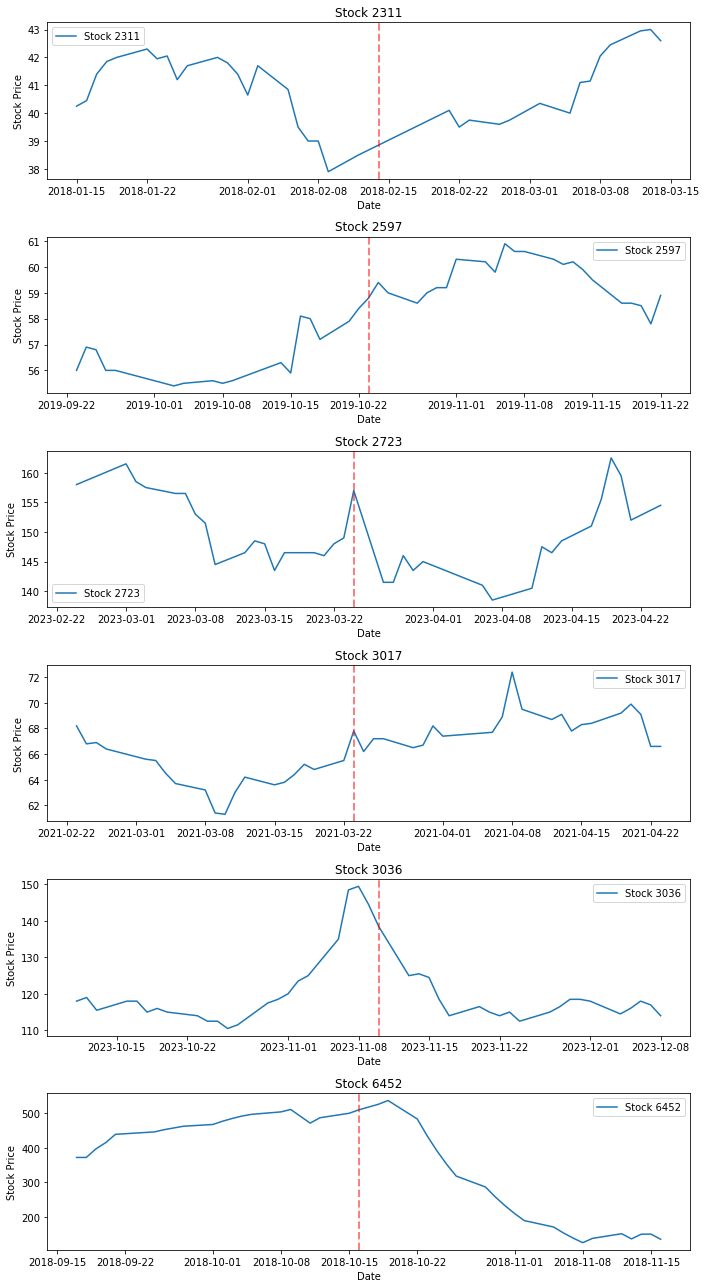

In [8]:
# 建立一個股價的dataframe，並且利用迴圈將final_data的資料帶入取得股票函數
result_df = pd.DataFrame(columns=['證券代碼', '年月日', '收盤價(元)'])
for count in range(len(final_data)):
    coid = final_data.iloc[count]['公司碼']
    data_coid = data_stock_price(coid, 
                                final_data.iloc[count]['start_date'], 
                                final_data.iloc[count]['end_date'])
    result_df = pd.concat([result_df, data_coid], ignore_index=True)

# 利用unique()取出單一證券代碼，避免重複
stock_codes_add = result_df['證券代碼'].unique()

# 利用subplots一個證券代碼畫一個圖，每個圖以申報日的前後一個月作為時間區間
fig, axs = plt.subplots(len(stock_codes_add), 1, figsize=(10, 3 * len(stock_codes_add)), sharex=False)

# 橫軸為日期，縱軸為收盤價(元)
for i, stock_code in enumerate(stock_codes_add):
    stock_data = result_df[result_df['證券代碼'] == stock_code]
    axs[i].plot(stock_data['年月日'].to_numpy(), stock_data['收盤價(元)'].to_numpy(), label=f"Stock {stock_code}")
    axs[i].legend()
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Stock Price')
    # 用紅虛線標出申報日，以利觀察申報前後之股票波動
    for date, code_add in zip(final_data['申報日'], final_data['公司碼']):
        if code_add == stock_code:
            axs[i].axvline(x=date, color='r', linestyle='--', alpha=0.5, linewidth=2)
            axs[i].set_title(f"Stock {stock_code}")

plt.legend()
plt.tight_layout()
plt.show()

In [9]:
all_data = all_data.reset_index()
all_data.drop(columns='index' , inplace=True)

In [12]:
# 找出申報日的下一個工作日，以利進行申報轉讓前後之對比
next_workdays = []
for c in range (len(all_data)):
    next_work_day = all_data['申報日'][c] + timedelta(days=1)
    next_working = str(next_work_day)[0:10]
    ROC_data = data_stock_price(all_data['公司碼'][c], str(all_data['申報日'][c])[0:10], next_working)
    while True:
        if len(ROC_data) < 2: # 如果資料少於兩筆代表目前只抓到申報日這天的股價資料，所以日期再繼續往後抓
            next_work_day += timedelta(days=1)
            next_working = str(next_work_day)[0:10]
            ROC_data = data_stock_price(all_data['公司碼'][c], str(all_data['申報日'][c])[0:10], next_working)
        else:
            break
    next_workdays.append(next_working)

all_data['下一個工作日'] = next_workdays

In [16]:
# 取得日報酬率函數，將證券碼、申報日與下一個工作日設為變數
def data_rate_of_return(coid, start, end):
    data_return = tejapi.get('TWN/APRCD2',                  # 上市(櫃)股價報酬(日)-報酬率資料庫   
                            coid = coid,
                            mdate = {'gte':start, 'lte':end},
                            opts = {'columns':['coid','mdate','zclose','roia']},    # 證券碼、日期、收盤價、日報酬率%
                            paginate = True,
                            chinese_column_name = True)
    return data_return

In [17]:
# 將申報日、下一個工作日與證券代碼代入日報酬率函數
ROC_df = pd.DataFrame(columns=['證券代碼', '年月日', '未調整收盤價(元)', '日報酬率 %'])
for count in range (len(all_data)):
    ROC_data = data_rate_of_return(all_data['公司碼'][count], 
                                    str(all_data['申報日'][count])[0:10], 
                                    str(all_data['下一個工作日'][count])[0:10])
    ROC_df = pd.concat([ROC_df, ROC_data], ignore_index=True)

ROC_df

,證券代碼,年月日,未調整收盤價(元),日報酬率 %
0,1101,2015-07-03,40.10,0.2500
1,1101,2015-07-06,39.55,-1.3716
2,1102,2009-04-03,34.00,4.6154
3,1102,2009-04-06,34.00,0.0000
4,1104,2015-05-29,28.95,-0.3442
...,...,...,...,...
971,9943,2011-03-22,28.95,0.3466
972,9951,2017-07-28,195.00,0.0000
973,9951,2017-07-31,197.50,1.2821
974,9962,2017-02-14,10.30,0.4878


In [19]:
# 計算正向、反向及無變動的數量
positive = 0
negative = 0
zero = 0
for i in range(1, len(ROC_df), 2):
    rate = ROC_df['日報酬率 %'][i]
    if rate == 0:
        zero += 1
    elif rate > 0:
        positive += 1
    elif rate < 0:
        negative += 1

total = zero+positive+negative

# 利用plotly套件畫出圓餅圖
labels = ['Zero', 'Positive', 'Negative']  # 資料標籤
values = [zero, positive, negative]  # 資料數值
colors = ['gold', 'mediumturquoise', 'darkorange']  # 顏色

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])  # 設定資料

fig.update_traces(hoverinfo='label+percent+value',  # 游標資訊
                    textinfo='percent+value+label',  # 圖上顯示資訊
                    textfont_size=15, # 字體大小
                    marker=dict(colors=colors, line=dict(color='#000000', width=1.5)))  # 不同標籤顏色、框線顏色與寬度

title_text = ("內部人持股轉讓後，下一個工作日股市變動情形圓餅圖，總資料筆數為{}筆" .format(total))  # 圖片主題
# fig.update_layout(title_text=title_text)
fig.show()